# Spotify Playlist Analysis

This is a tool to analyze and process Spotify Playlist using the Spotify Web API (https://developer.spotify.com/documentation/web-api/) and Spotipy library.

Made by Julian Karlbauer (julian.karlbauer@uni-ulm.de).
No claim for completeness or correct functionality.

Date: 28.01.2022

## 1. Setup

In [ ]:
#install dependencies
!pip install wget
!pip install spotipy

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import wget #for preview download
import os #for file rename
from math import pi

In [4]:
#setup authentification according to https://levelup.gitconnected.com/extracting-and-analysing-spotify-tracks-with-python-d1466fc1dfee
#auth_manager = SpotifyClientCredentials(client_id = '3b7d9560361541528f2c6852924a9f9b',
#                                        client_secret = 'e64ff71138a74233b2f3409373d2a043')
#sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
#setup authentification according to https://levelup.gitconnected.com/extracting-and-analysing-spotify-tracks-with-python-d1466fc1dfee
auth_manager = SpotifyClientCredentials(client_id = 'your client ID',
                                        client_secret = 'your client secret')
sp = spotipy.Spotify(auth_manager=auth_manager)

## 2. Core Functionality

In [5]:
'''finds playlists (id, name, trackcount, followers, owner) using a query token and puts them into a dataframe.
Only includes playlist with minimum follower count defined in threshold.'''
def getPlaylists(token, threshold = 100000):
    playlist_ids = []
    results = sp.search(token, limit = 10, type = 'playlist', offset = 0)['playlists']
    elements = results['items']
    while results['next']: 
        if results['offset'] <= 100:  
            results = sp.next(results)['playlists']
            elements.extend(results['items'])
        else:
            break
    playlists = []
    
    for item in elements:
        playlist_info = []
        playlist_owner = item['owner']['display_name']
        playlist_id = item['id']
        playlist_name = item['name']
        trackcount = item['tracks']['total']
        playlist_ids.append(playlist_id)
        r = sp.playlist(playlist_id)
        followers = r['followers']['total']
        
        #only consider popular playlists (100.000)
        if followers >= threshold:
            playlist_info.append(playlist_id)
            playlist_info.append(playlist_name)
            playlist_info.append(trackcount)
            playlist_info.append(followers)
            playlist_info.append(playlist_owner)
            playlists.append(playlist_info)

    df = pd.DataFrame(playlists, columns = ['id','name', 'trackcount', 'followers', 'owner'])
    return df
        
'''downloads 30s song sample for given song id'''
def getTrackPreview(id, iterator = -1):
    track_info = sp.track(id)
    preview_url = track_info['preview_url']
    if(preview_url):
        file = wget.download(preview_url)
        if iterator == -1:
            os.rename(file, file +'.mp3')
        else:
            os.rename(file, str(iterator) + '.mp3')
        
    return

'''finds all track IDs from a list of spotify playlist IDs'''
def getTrackIDs(playlist_ids, user = 'spotify'):
    ids = []
    for playlist_id in playlist_ids:
        results = sp.playlist_tracks(playlist_id)
        elements = results['items']
        while results['next']:
            results = sp.next(results)
            elements.extend(results['items'])
        for item in elements:
            track = item['track']
            if track:
                if track['id']:
                    ids.append(track['id'])
    return ids  

'''get track information (info, features) from a track ID'''
def getTrackFeatures(id):
    track_info = sp.track(id)
    features_info = sp.audio_features(id)
    
    if not features_info[0]:
        return []
    
    #Track info
    name = track_info['name']
    album = track_info['album']['name']
    artist = track_info['album']['artists'][0]['name']
    release_date = track_info['album']['release_date']
    length = track_info['duration_ms']
    popularity = track_info['popularity']

    #Track features
    acousticness = features_info[0]['acousticness']
    danceability = features_info[0]['danceability']
    energy = features_info[0]['energy']
    valence = features_info[0]['valence']
    instrumentalness = features_info[0]['instrumentalness']
    liveness = features_info[0]['liveness']
    loudness = features_info[0]['loudness']
    speechiness = features_info[0]['speechiness']
    tempo = features_info[0]['tempo']
    time_signature = features_info[0]['time_signature']
    key = features_info[0]['key']
    mode = features_info[0]['mode']
    track_data = [valence, energy]
    #track_data = [name, album, artist, release_date, length, popularity, acousticness,
                #danceability, energy, valence, instrumentalness, liveness, loudness,
                #speechiness, tempo, time_signature, key, mode]

    return track_data

'''genearate a dataframe containing the features of all passed track IDs'''
def generateDataFrame(track_ids):
    track_list = []
    for i in range(len(track_ids)):
        #time.sleep(.3)
        track_data = getTrackFeatures(track_ids[i])
        track_list.append(track_data)

    playlist_data = pd.DataFrame(track_list, columns =['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'acousticness',
                  'danceability', 'energy', 'valence', 'instrumentalness', 'liveness', 'loudness',
                  'speechiness', 'tempo', 'time_signature', 'key', 'mode'] )
  
    return playlist_data

'''remove defined columns from a dataframe to simplify plotting'''
def clearDataFrame(dataframe):
    df_cleared = dataframe.drop(['name', 'artist', 'release_date', 'album', 'time_signature', 'loudness', 'key', 'popularity', 'length', 'tempo', 'mode'], axis = 1)
    return df_cleared

'''plot a collection of dataframes in a radar plot'''
def radarPlotDataframes(dataframes):
    if len(dataframes) > 6:
        print("too many dataframes")
        return

    labels = list(dataframes[0])[:]
  
    colors = ["orange", "blue", "green", "yellow", "purple", "red"]

    features = []
    for dataframe in dataframes:
        features.append(dataframe.mean().tolist())

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)

    figure = plt.figure(figsize=(18,18))
  
    #for having multiple seperate plots
    figures = []
    for dataframe in dataframes:
        fig = plt.figure(figsize=(18,18))
        figures.append(fig)

    for i in range(len(figures)):
        ax = figure.add_subplot(221, polar=True)
        ax.plot(angles, features[i], 'o-', linewidth=2, label = 'label', color= colors[i])
        ax.fill(angles, features[i], alpha=0.25, facecolor=colors[i])
        ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13) 



## 3. Plotting

### 3.1 Valence-Arousal Planes

In [ ]:
'''find playlists using query-token = aggressive and download song previews'''

df = getPlaylists('aggressive', 1000)

all_tids = []#non duplicate list
duplicates = 0
for index, row in df.iterrows():
    tids = getTrackIDs([row['id']])
    for tid in tids:
        if not tid in all_tids:
            all_tids.append(tid)
        else:
            duplicates += 1 #count duplicate ids
            print("duplicate nr.: " + str(duplicates))
            
cnt = 0
for tid in all_tids:
    getTrackPreview(tid, cnt)
    cnt += 1


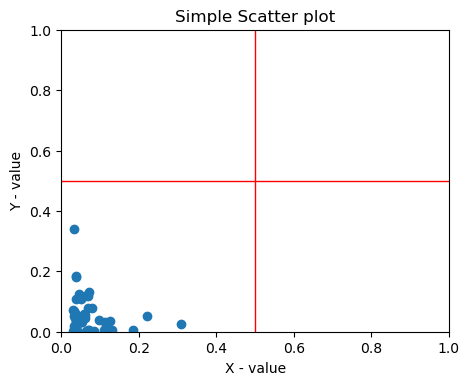

In [40]:
#plot VA-Plane for given playlist
arousal_vals = []
valence_vals = []

for tid in getTrackIDs(['37i9dQZF1DXbm0dp7JzNeL']):
    features = getTrackFeatures(tid)
    valence_vals.append(features[0])
    arousal_vals.append(features[1])
    

x = valence_vals
y = arousal_vals
plt.scatter(x, y)
plt.rcParams.update({'figure.figsize':(5,4), 'figure.dpi':100})
plt.title('Simple Scatter plot')
plt.xlabel('X - value')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Y - value')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )
plt.show()



In [52]:
#get all ids for specific VA values
df = getPlaylists('aggressive', 1000)
ids = []
all_tids = []#non duplicate list
for index, row in df.iterrows():
    tids = getTrackIDs([row['id']])
    for tid in tids:
        if not tid in all_tids:
            all_tids.append(tid)

    
    


In [53]:
#filter for specific valence and arousal values to crop the dataset       
for tid in all_tids:
    features = getTrackFeatures(tid)
    if(len(features) > 0):
        if features[0] <= 0.5 and features[1] >= 0.5:
            ids.append(tid)

In [54]:
#VA-Plane sad songs
arousal_vals_cropped = []
valence_vals_cropped = []

for tid in ids:
    features = getTrackFeatures(tid)
    #print(features)
    if len(features) > 0:
        valence_vals_cropped.append(features[0])
        arousal_vals_cropped.append(features[1])
    


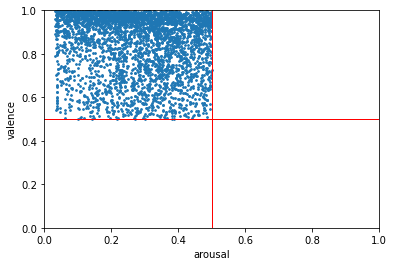

In [56]:
x_angry_cropped = valence_vals_cropped
y_angry_cropped = arousal_vals_cropped

plt.scatter(x_angry_cropped, y_angry_cropped, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

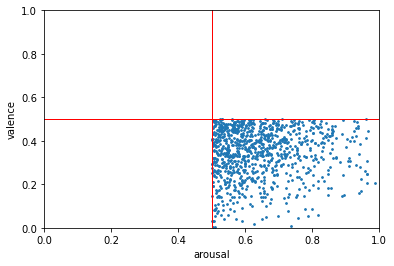

In [48]:
x_chill_cropped = valence_vals_cropped
y_chill_cropped = arousal_vals_cropped

plt.scatter(x_chill_cropped, y_chill_cropped, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

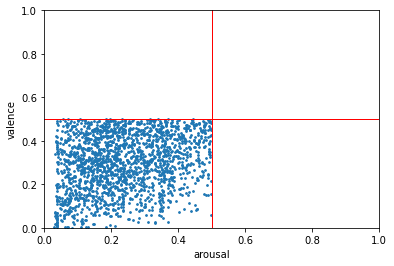

In [36]:
x_sad_cropped = valence_vals_cropped_sad
y_sad_cropped = arousal_vals_cropped_sad

plt.scatter(x_sad_cropped, y_sad_cropped, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

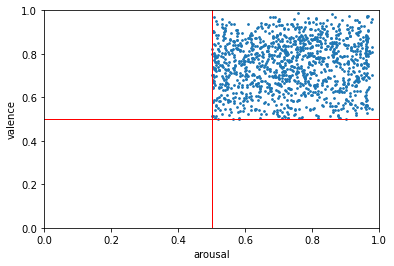

In [19]:
x_happy_cropped = valence_vals_cropped
y_happy_cropped = arousal_vals_cropped

plt.scatter(x_happy_cropped, y_happy_cropped, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

In [97]:
#VA-Plane sad songs
arousal_vals = []
valence_vals = []

for tid in all_tids:
    features = getTrackFeatures(tid)
    #print(features)
    if len(features) > 0:
        valence_vals.append(features[0])
        arousal_vals.append(features[1])
    


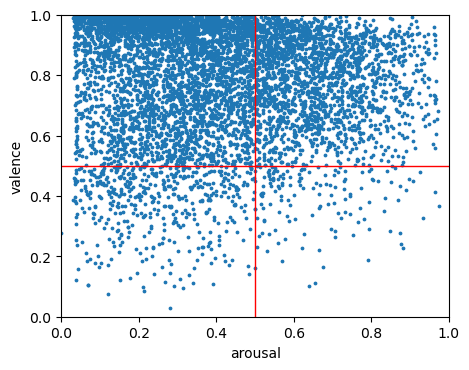

In [91]:
#x_angry = valence_vals
#y_angry = arousal_vals

plt.scatter(x_angry, y_angry, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

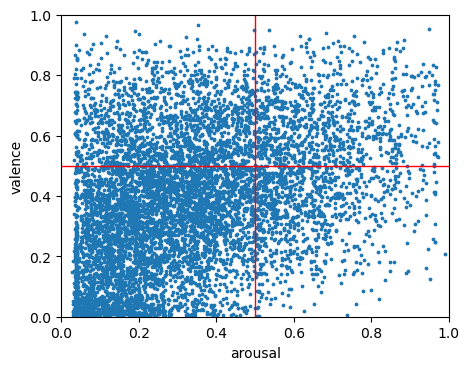

In [95]:
#x_chill = valence_vals
#y_chill = arousal_vals

plt.scatter(x_chill, y_chill, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

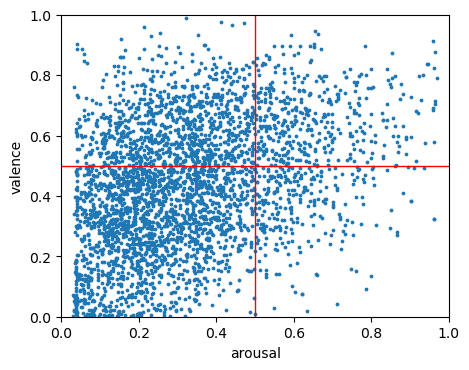

In [77]:
#x_sad = valence_vals
#y_sad = arousal_vals

plt.scatter(x_sad, y_sad, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

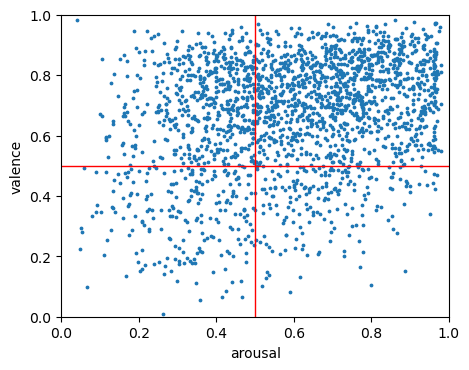

In [98]:
x_happy = valence_vals
y_happy = arousal_vals

plt.scatter(x_happy, y_happy, s = 3)
plt.xlabel('arousal')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('valence')
plt.plot([0.5,0.5],[0,1], linewidth=1, color='red' )
plt.plot([0,1],[0.5,0.5], linewidth=1, color='red' )

### 3.2 Radar Plots

<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

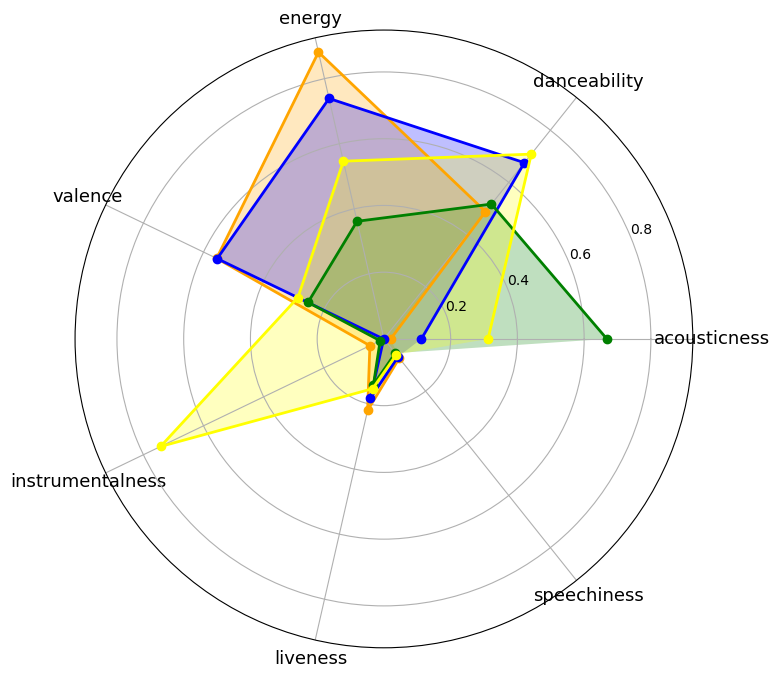

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [75]:
## playlist
angry = '37i9dQZF1DWZVAVMhIe3pV'
happy = '37i9dQZF1DXdPec7aLTmlC'
sad = '37i9dQZF1DX7qK8ma5wgG1'
chill = '37i9dQZF1DWTvNyxOwkztu'

ids_angry = getTrackIDs([angry])
ids_happy = getTrackIDs([happy])
ids_sad = getTrackIDs([sad])
ids_chill = getTrackIDs([chill])
df_angry = clearDataFrame(generateDataFrame(ids_angry))
df_happy = clearDataFrame(generateDataFrame(ids_happy))
df_sad = clearDataFrame(generateDataFrame(ids_sad))
df_chill = clearDataFrame(generateDataFrame(ids_chill))
radarPlotDataframes([df_angry, df_happy, df_sad, df_chill])

['37i9dQZF1DXdPec7aLTmlC', '37i9dQZF1DWSf2RDTDayIx', '37i9dQZF1DX0HWhBzpBj05', '37i9dQZF1DX1WSnLRtI26o', '37i9dQZF1DX84kJlLdo9vT', '37i9dQZF1DX0UrRvztWcAU']


<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

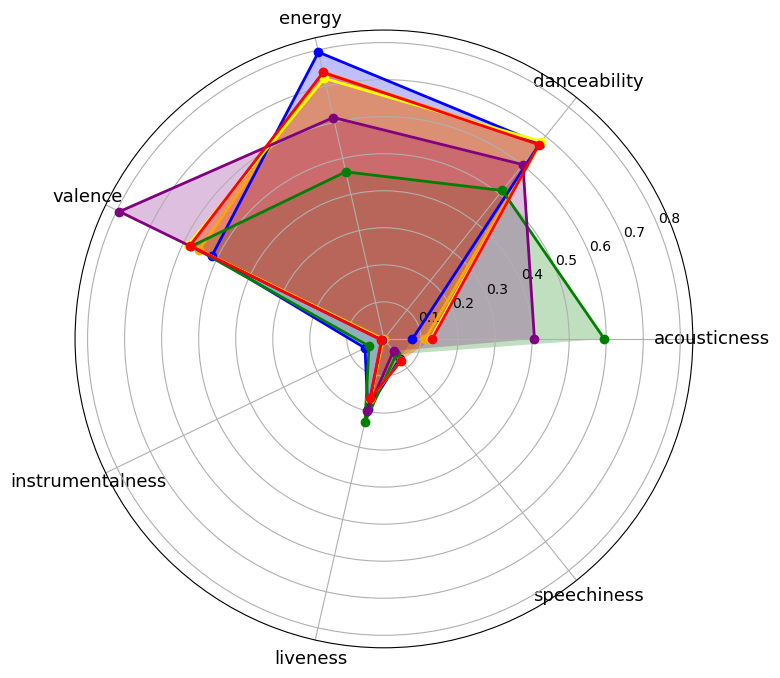

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [91]:
df_happy_playlists = getPlaylists('happy')

pl_ids = []
i = 0
for index, row in df_happy_playlists.iterrows():
    pid = row['id']
    if i < 6:
        pl_ids.append(pid)
    i = i+1
    
print(pl_ids)
        
idss = []
for pid in pl_ids:
    idss.append(getTrackIDs([pid]))
    
dfs = []
for ids in idss:
    dfs.append(clearDataFrame(generateDataFrame(ids)))
    
radarPlotDataframes(dfs)

['37i9dQZF1DWSqBruwoIXkA', '37i9dQZF1DWZQGZ7yvpH00', '3c0Nv5CY6TIaRszlTZbUFk', '4yXfnhz0BReoVfwwYRtPBm', '37i9dQZF1DWW2hj3ZtMbuO', '37i9dQZF1DWVV27DiNWxkR']


<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

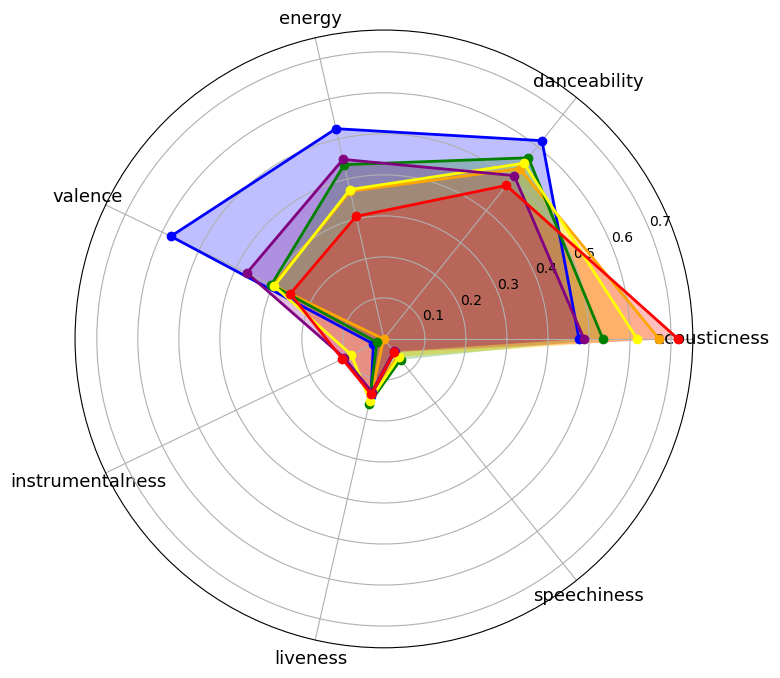

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [90]:
df_happy_playlists = getPlaylists('sad')

pl_ids = []
i = 0
for index, row in df_happy_playlists.iterrows():
    pid = row['id']
    if i < 6:
        pl_ids.append(pid)
    i = i+1
    
print(pl_ids)
 

        
idss = []
for pid in pl_ids:
    idss.append(getTrackIDs([pid]))
    
dfs = []
for ids in idss:
    dfs.append(clearDataFrame(generateDataFrame(ids)))
    
radarPlotDataframes(dfs)
    

['37i9dQZF1DX3Ogo9pFvBkY', '37i9dQZF1DX4WYpdgoIcn6', '37i9dQZF1DX889U0CL85jj', '37i9dQZF1DWTkxQvqMy4WW', '37i9dQZF1DWYGZAMYFDM8S', '37i9dQZF1DX2UgsUIg75Vg']


<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

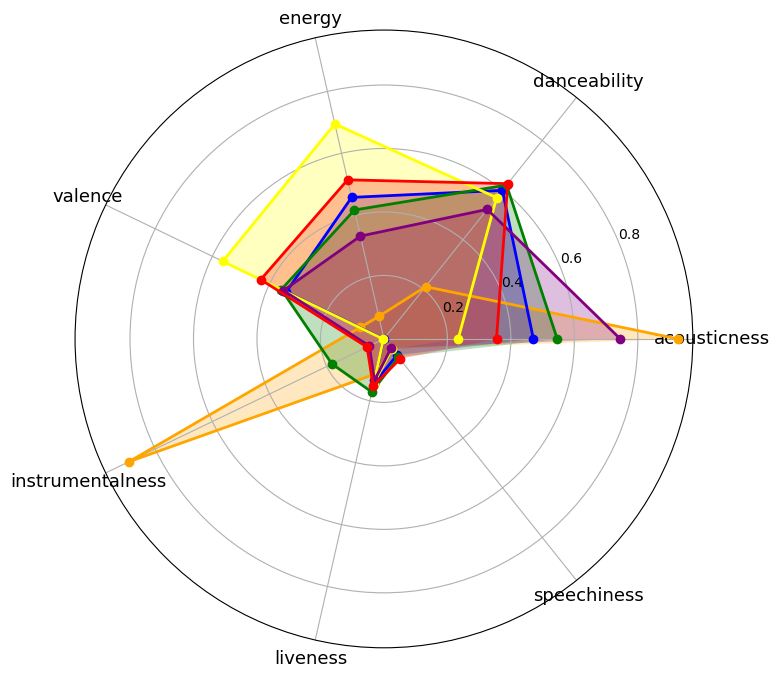

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [92]:
df_happy_playlists = getPlaylists('chill')

pl_ids = []
i = 0
for index, row in df_happy_playlists.iterrows():
    pid = row['id']
    if i < 6:
        pl_ids.append(pid)
    i = i+1
    
print(pl_ids)
 

        
idss = []
for pid in pl_ids:
    idss.append(getTrackIDs([pid]))
    
dfs = []
for ids in idss:
    dfs.append(clearDataFrame(generateDataFrame(ids)))
    
radarPlotDataframes(dfs)
    

['3i27pZJXTon1DDWfuMu3p9', '37i9dQZF1DX4eRPd9frC1m', '37i9dQZF1DX1fmyMdW2PaL', '6SZt39ktXkhy8WUJe1CRUv', '3aS8WMIRAct155pR3FgT0B']


<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = figure.add_subplot(221, polar=True)
<ipython-input-73-c5e219fe835a>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, 

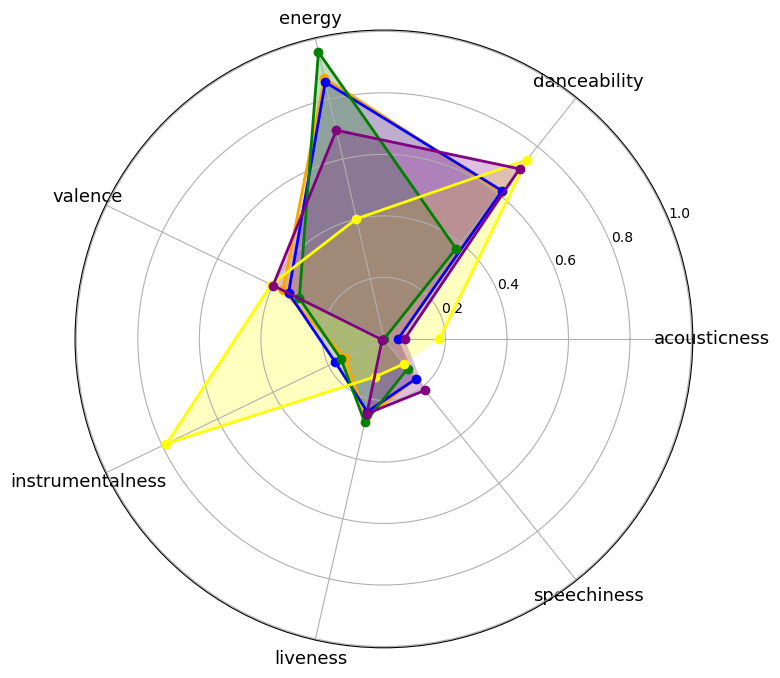

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

In [122]:
df_happy_playlists = getPlaylists('aggressive')

pl_ids = []
i = 0
for index, row in df_happy_playlists.iterrows():
    pid = row['id']
    if i < 6:
        pl_ids.append(pid)
    i = i+1
    
print(pl_ids)
 

        
idss = []
for pid in pl_ids:
    idss.append(getTrackIDs([pid]))
    
dfs = []
for ids in idss:
    dfs.append(clearDataFrame(generateDataFrame(ids)))
    
radarPlotDataframes(dfs)